Import packages needed

In [33]:
#%%
#* Import the code needed
import os
from pathlib import Path
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import  norm, lognorm
from typing import List
import warnings

Set directory path

In [34]:
#%%
#* Define paths
directory_path = Path('../../')

Import datasets

In [35]:
pop = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Population' / 'regression_Population.xlsx',
    index_col=0)

PpD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'PpD' / 'regression_PpD.xlsx',
    index_col=0)

UFApD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'UFApD' / 'regression_UFApD.xlsx',
    index_col=0)

energy_intensity = pd.read_excel(
    directory_path / 'data' / 'cleaned_and_combined_data' / 'Energy_Intensity' / 'Energy_intensity_constants.xlsx',
    index_col=[0,1,2])

TS_cj = pd.read_excel(
    directory_path / 'data' / 'cleaned_and_combined_data' / 'Type_Split' / 'type_split_clean.xlsx',
    index_col=0)

lifetime = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Dwelling_Lifetime' / 'lifetime_regression.xlsx',
    index_col=0)

lifetime_standard_deviation = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Dwelling_Lifetime' / 'lifetime_regression.xlsx',
    index_col=0)

Seperate out the lifetime and standard deviation datasets

In [36]:
#lifetime = lifetime.drop('std_dev', axis=1)
lifetime_standard_deviation = lifetime_standard_deviation.drop('Avg_lifetime', axis=1)

lifetime = lifetime.loc[:, 'Avg_lifetime'].to_numpy()
lifetime

lifetime_standard_deviation = lifetime_standard_deviation.loc[:, 'std_dev'].to_numpy()

Import DSM module

In [37]:
# getting the name of the directory where the this file is present.
current = os.path.dirname(os.path.realpath('this'))
 
# Getting the parent directory name where the current directory is present.
parent = os.path.dirname(current)
#make the UA path
module_path = parent + '/modules'
#append path to options to import from
sys.path.append(module_path)

from dynamic_stock_model import DynamicStockModel
import renovation_state_modeling as r_s_m
from importlib import reload
reload(r_s_m)
from renovation_state_modeling import get_renovation_cycles
from renovation_state_modeling import RenovationStock
from renovation_state_modeling import EnergyIntensity

Calculate stock from pop/PpD

In [38]:
stock_t = np.divide(pop.drop_duplicates(),PpD)

C:\Users\grace\AppData\Local\Temp\ipykernel_35632\4106792660.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  stock_t = np.divide(pop.drop_duplicates(),PpD)


Define a function that does the stock driven modeling

In [39]:
def calculate_inflow_by_type(inflow_t):
    SFH_inflow = pd.DataFrame()
    TH_inflow = pd.DataFrame()
    AB_inflow = pd.DataFrame()
    for year in inflow_t.columns:
        if int(year) <= 1900:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['before 1900','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['before 1900','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['before 1900','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        if int(year) >= 1901 and int(year) <= 1955:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1901-1955','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1901-1955','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1901-1955','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1956 - 1970','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1956 - 1970','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1956 - 1970','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1971 - 1980','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1971 - 1980','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1971 - 1980','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1981 - 1990','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1981 - 1990','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1981 - 1990','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1991 - 2000','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1991 - 2000','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1991 - 2000','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['2001 - 2010','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['2001 - 2010','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['2001 - 2010','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 2011:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['2011 and after','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['2011 and after','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['2011 and after','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
    return SFH_inflow, TH_inflow, AB_inflow

In [40]:
def stock_driven_model(stock):
    dwellings_stock_driven = DynamicStockModel(t=np.arange(1600, 2051),
                         s=stock['Pop'].to_numpy(),
                         lt={'Type': 'Normal', 
                             'Mean': lifetime,
                             'StdDev': lifetime_standard_deviation 
                             }
                        )
    
    dwellings_stock_driven.compute_stock_driven_model(
        NegativeInflowCorrect = True)
    
    inflow_t = pd.DataFrame(dwellings_stock_driven.i, index=np.arange(1600,2051))
    
    inflow_t_SFH, inflow_t_TH, inflow_t_AB = calculate_inflow_by_type(inflow_t.T)
    inflow_t_SFH = inflow_t_SFH.T
    inflow_t_TH = inflow_t_TH.T
    inflow_t_AB = inflow_t_AB.T
    
    return inflow_t_SFH, inflow_t_TH, inflow_t_AB

Run the stock driven model

In [41]:
i_SFH, i_TH, i_AB = stock_driven_model(stock_t)

Define a function that does the inflow driven modeling

In [42]:
def inflow_driven_model(inflow):
    dwellings_inflow_driven = DynamicStockModel(t=np.arange(1600, 2051),
                    i=inflow[0],
                    lt={'Type': 'Normal', 
                        'Mean': lifetime,
                        'StdDev': lifetime_standard_deviation 
                        }
                    )
    dwellings_inflow_driven.compute_s_c_inflow_driven()

    dwellings_inflow_driven.compute_stock_total()

    dwellings_inflow_driven.compute_o_c_from_s_c()

    return dwellings_inflow_driven.s_c, dwellings_inflow_driven.s, dwellings_inflow_driven.o_c

Run the inflow driven model

In [43]:
s_c_SFH, s_SFH, o_SFH = inflow_driven_model(i_SFH)
s_c_TH, s_TH, o_TH = inflow_driven_model(i_TH)
s_c_AB, s_AB, o_AB = inflow_driven_model(i_AB)

In [44]:
i_SFH.rename(columns={0:'SFH'}, inplace=True)
i_TH.rename(columns={0:'TH'}, inplace=True)
i_AB.rename(columns={0:'AB'}, inplace=True)

Make s_c arrays into dataframes for easier use

In [45]:
UFApD.drop_duplicates(inplace=True)

s_SFH_df = pd.DataFrame(s_SFH)
s_SFH_df = s_SFH_df.set_index(UFApD.index)
s_SFH_df.columns = ['SFH']

s_TH_df = pd.DataFrame(s_TH)
s_TH_df = s_TH_df.set_index(UFApD.index)
s_TH_df.columns = ['TH']

s_AB_df = pd.DataFrame(s_AB)
s_AB_df = s_AB_df.set_index(UFApD.index)
s_AB_df.columns = ['AB']

s_c_SFH_df = pd.DataFrame(s_c_SFH)
s_c_SFH_df = s_c_SFH_df.set_index(UFApD.index)
s_c_SFH_df.columns = np.arange(1600, 2051)

s_c_TH_df = pd.DataFrame(s_c_TH)
s_c_TH_df = s_c_TH_df.set_index(UFApD.index)
s_c_TH_df.columns = np.arange(1600, 2051)

s_c_AB_df = pd.DataFrame(s_c_AB)
s_c_AB_df = s_c_AB_df.set_index(UFApD.index)
s_c_AB_df.columns = np.arange(1600, 2051)

i_SFH_df = pd.DataFrame(i_SFH)
i_SFH_df = i_SFH_df.set_index(UFApD.index)

o_SFH_df = pd.DataFrame(o_SFH)
o_SFH_df = o_SFH_df.set_index(UFApD.index)
o_SFH_df.columns = np.arange(1600, 2051)

i_TH_df = pd.DataFrame(i_TH)
i_TH_df = i_TH_df.set_index(UFApD.index)

o_TH_df = pd.DataFrame(o_TH)
o_TH_df = o_TH_df.set_index(UFApD.index)
o_TH_df.columns = np.arange(1600, 2051)

i_AB_df = pd.DataFrame(i_AB)
i_AB_df = i_AB_df.set_index(UFApD.index)

o_AB_df = pd.DataFrame(o_AB)
o_AB_df = o_AB_df.set_index(UFApD.index)
o_AB_df.columns = np.arange(1600, 2051)

Aggregate s_c dataframes into the cohorts from tabula for each type for plotting

In [46]:
SFH_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_SFH_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_SFH_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_SFH_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_SFH_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_SFH_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_SFH_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_SFH_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

TH_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_TH_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_TH_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_TH_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_TH_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_TH_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_TH_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_TH_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

AB_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_AB_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_AB_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_AB_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_AB_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_AB_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_AB_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_AB_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

Calculate total stock (s_total), total stock by cohort (s_c_total)

Calculate stock_changes by inflow - outflow for each type and aggregated

Calculate total inflows and outflows

In [47]:
s_total = s_SFH_df + s_TH_df + s_AB_df

total_stock_by_tabula_cohort = SFH_stock_by_tabula_cohort + TH_stock_by_tabula_cohort + AB_stock_by_tabula_cohort

stock_change_SFH = i_SFH_df.values - pd.DataFrame(o_SFH_df.sum(axis=1))
stock_change_SFH = pd.DataFrame(stock_change_SFH, index=np.arange(1600,2051))

stock_change_TH = i_TH_df.values - pd.DataFrame(o_TH_df.sum(axis=1))
stock_change_TH = pd.DataFrame(stock_change_TH, index=np.arange(1600,2051))

stock_change_AB = i_AB_df.values - pd.DataFrame(o_AB_df.sum(axis=1))
stock_change_AB = pd.DataFrame(stock_change_AB, index=np.arange(1600,2051))

stock_change_total = stock_change_SFH + stock_change_TH + stock_change_AB

i_total = i_SFH_df.values + i_TH_df.values + i_AB_df.values
i_total = pd.DataFrame(i_total, index=np.arange(1600,2051))

o_total = o_SFH_df + o_TH_df + o_AB_df

Convert number of dwellings into floor area by DSM cohort

In [48]:
s_UFA_c_SFH = s_c_SFH_df @ np.diag(UFApD['UFApD SFH'])
s_UFA_c_SFH = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH.columns = np.arange(1600, 2051)

s_UFA_c_TH = s_c_TH_df @ np.diag(UFApD['UFApD TH'])
s_UFA_c_TH = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH.columns = np.arange(1600, 2051)

s_UFA_c_AB = s_c_AB_df @ np.diag(UFApD['UFApD AB'])
s_UFA_c_AB = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB.columns = np.arange(1600, 2051)

i_SFH_UFA = i_SFH_df.mul(UFApD['UFApD SFH'].values, axis=0)
i_SFH_UFA = pd.DataFrame(i_SFH_UFA)

o_SFH_UFA = o_SFH_df @ np.diag(UFApD['UFApD SFH'])
o_SFH_UFA = pd.DataFrame(o_SFH_UFA)
o_SFH_UFA.columns = np.arange(1600, 2051)

i_TH_UFA = i_TH_df.mul(UFApD['UFApD TH'].values, axis=0)
i_TH_UFA = pd.DataFrame(i_TH_UFA)

o_TH_UFA = o_TH_df @ np.diag(UFApD['UFApD TH'])
o_TH_UFA = pd.DataFrame(o_TH_UFA)
o_TH_UFA.columns = np.arange(1600, 2051)

i_AB_UFA = i_AB_df.mul(UFApD['UFApD AB'].values, axis=0)
i_AB_UFA = pd.DataFrame(i_AB_UFA)

o_AB_UFA = o_AB_df @ np.diag(UFApD['UFApD AB'])
o_AB_UFA = pd.DataFrame(o_AB_UFA)
o_AB_UFA.columns = np.arange(1600, 2051)

Make s_c_UFA arrays into dataframes for easier use

In [49]:
UFApD.drop_duplicates(inplace=True)

s_UFA_c_SFH_df = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH_df = s_UFA_c_SFH_df.set_index(UFApD.index)
s_UFA_c_SFH_df.columns = np.arange(1600, 2051)
s_UFA_c_SFH_df

s_UFA_c_TH_df = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH_df = s_UFA_c_TH_df.set_index(UFApD.index)
s_UFA_c_TH_df.columns = np.arange(1600, 2051)
s_UFA_c_TH_df

s_UFA_c_AB_df = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB_df = s_UFA_c_AB_df.set_index(UFApD.index)
s_UFA_c_AB_df.columns = np.arange(1600, 2051)
s_UFA_c_AB_df

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004402e+06,1.009507e+06,1.014769e+06,1.020193e+06,1.025783e+06,1.031541e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004402e+06,1.009507e+06,1.014769e+06,1.020193e+06,1.025783e+06,1.031541e+06,1.037471e+06,0.000000e+00,0.000000e+00,0.000000e+00
2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.004401e+06,1.009506e+06,1.014769e+06,1.020193e+06,1.025782e+06,1.031541e+06,1.037471e+06,1.043574e+06,0.000000e+00,0.000000e+00


Aggregate s_c dataframes into the cohorts from tabula for each type for plotting

In [50]:
SFH_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_SFH_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

TH_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_TH_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_TH_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_TH_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

AB_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_AB_df).loc[:,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_AB_df).loc[:,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_AB_df).loc[:,'2011':'2050'].sum(axis=1)}
          )

Calculate total stock (s_total), total stock by cohort (s_c_total)

Calculate stock_changes by inflow - outflow for each type and aggregated

Calculate total inflows and outflows

In [51]:
s_UFA_total = s_UFA_c_SFH.sum(axis=1) + s_UFA_c_TH.sum(axis=1) + s_UFA_c_AB.sum(axis=1)

total_stock_UFA_by_tabula_cohort = SFH_UFA_stock_by_tabula_cohort + TH_UFA_stock_by_tabula_cohort + AB_UFA_stock_by_tabula_cohort

stock_change_SFH_UFA = i_SFH_UFA.values - pd.DataFrame(o_SFH_UFA.sum(axis=1))
stock_change_SFH_UFA = pd.DataFrame(stock_change_SFH_UFA, index=np.arange(1600,2051))

stock_change_TH_UFA = i_TH_UFA.values - pd.DataFrame(o_TH_UFA.sum(axis=1))
stock_change_TH_UFA = pd.DataFrame(stock_change_TH_UFA, index=np.arange(1600,2051))

stock_change_AB_UFA = i_AB_UFA.values - pd.DataFrame(o_AB_UFA.sum(axis=1))
stock_change_AB_UFA = pd.DataFrame(stock_change_AB_UFA, index=np.arange(1600,2051))

stock_change_total_UFA = stock_change_SFH_UFA + stock_change_TH_UFA + stock_change_AB_UFA

i_total_UFA = i_SFH_UFA.values + i_TH_UFA.values + i_AB_UFA.values
i_total_UFA = pd.DataFrame(i_total_UFA, index=np.arange(1600,2051))

o_total_UFA = o_SFH_UFA + o_TH_UFA + o_AB_UFA

Do renovation modeling AFTER conversion to UFA

Start with setting up renovation cycle

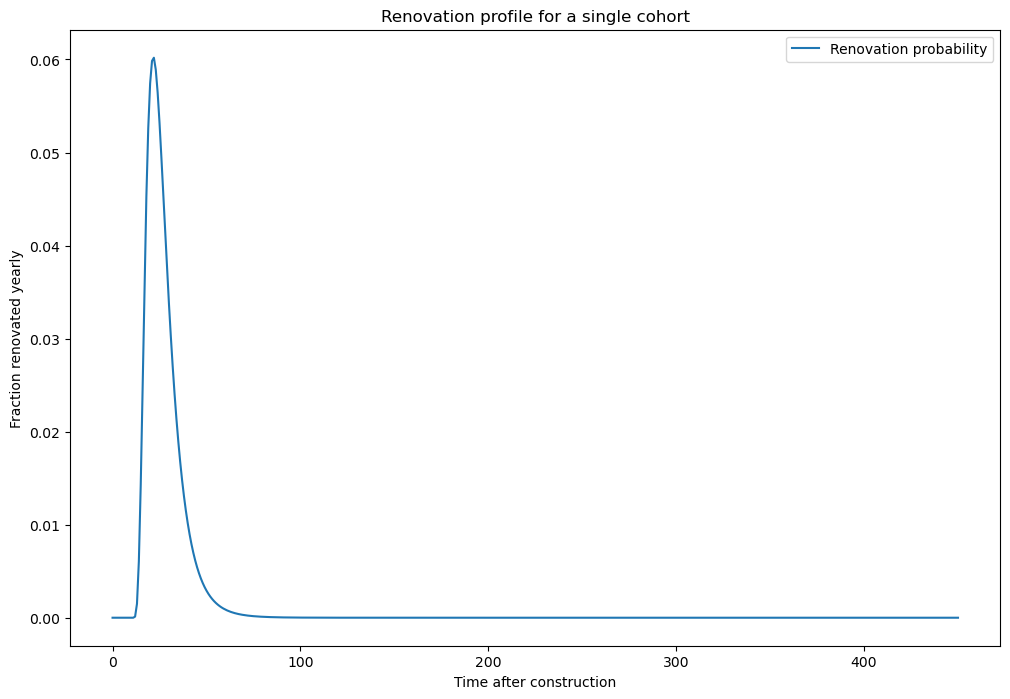

the actual mean of the outflow time in the first renovation cycles is at 27.0 years.


In [52]:
time_interval = [0, s_UFA_c_SFH_df.index[-1] - s_UFA_c_SFH_df.index[0]]
#time_interval = [1600, 2050]
#[1980, 2050] # for age of the cohorts

no_cycles = 1
ren_mean_avg = 20
ren_rel_std = 0.25

renovation_cycle_avg = get_renovation_cycles(time_interval, no_cycles, ren_mean_cycle= ren_mean_avg, ren_rel_deviation = ren_rel_std, distribution='lognorm', show = True)

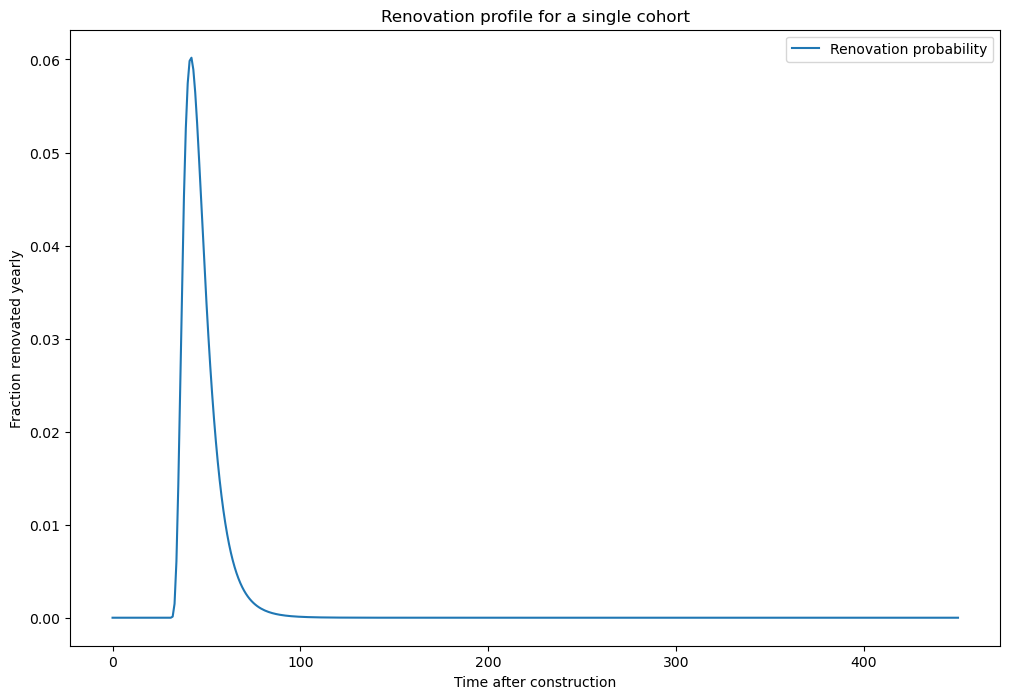

the actual mean of the outflow time in the first renovation cycles is at 47.0 years.


In [53]:
time_interval = [0, int(s_UFA_c_SFH_df.index[-1]) - int(s_UFA_c_SFH_df.index[0])]
#time_interval = [1600, 2050]
#[1980, 2050] # for age of the cohorts

no_cycles = 1
ren_mean_adv = 20
ren_rel_std = .25

renovation_cycle_adv = get_renovation_cycles(time_interval, no_cycles, ren_mean_cycle= ren_mean_adv, ren_rel_deviation = ren_rel_std, loc=20, distribution='lognorm', show = True)

Expand stock model by renovation for each type 

# (NEED TO FIX MODEL SO THAT RENOVATIONS DON'T HAPPEN UNTIL THE 80S)

In [54]:
s_UFA_c_SFH

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,2.384715e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,2.384629e+07,2.870025e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,2.384537e+07,2.869922e+04,2.913639e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,2.384438e+07,2.869811e+04,2.913534e+04,2.958181e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,2.384331e+07,2.869692e+04,2.913422e+04,2.958075e+04,3.003684e+04,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,6.689743e-04,9.337629e-07,1.098894e-06,1.292722e-06,1.520148e-06,1.786898e-06,0.000002,0.000002,0.000003,0.000003,...,2.056564e+06,2.063808e+06,2.071338e+06,2.079163e+06,2.087288e+06,2.095718e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,5.765299e-04,8.051149e-07,9.479510e-07,1.115691e-06,1.312604e-06,1.543677e-06,0.000002,0.000002,0.000003,0.000003,...,2.056563e+06,2.063807e+06,2.071338e+06,2.079163e+06,2.087288e+06,2.095718e+06,2.104457e+06,0.000000e+00,0.000000e+00,0.000000e+00
2048,4.966212e-04,6.938574e-07,8.173483e-07,9.624411e-07,1.132851e-06,1.332920e-06,0.000002,0.000002,0.000002,0.000003,...,2.056562e+06,2.063807e+06,2.071337e+06,2.079162e+06,2.087287e+06,2.095718e+06,2.104457e+06,2.113507e+06,0.000000e+00,0.000000e+00


In [55]:
o_SFH_UFA

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,10362.960615,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1601,855.879856,1.247191e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,920.971929,1.030059e+00,1.266144e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1603,990.527887,1.108398e+00,1.045712e+00,1.285500e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1604,1064.813984,1.192109e+00,1.125241e+00,1.061698e+00,1.305273e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.000107,1.486837e-07,1.743652e-07,2.044005e-07,2.395141e-07,2.805491e-07,3.284859e-07,3.844642e-07,4.498088e-07,5.260588e-07,...,0.599837,0.467459,0.363261,0.281491,0.217512,0.710883,0.000000,0.000000,0.000000,0.000000
2047,0.000092,1.286480e-07,1.509429e-07,1.770305e-07,2.075442e-07,2.432213e-07,2.849198e-07,3.336377e-07,3.905355e-07,4.569620e-07,...,0.764849,0.597819,0.465939,0.362124,0.280646,0.216889,0.708361,0.000000,0.000000,0.000000
2048,0.000080,1.112575e-07,1.306027e-07,1.532502e-07,1.797532e-07,2.107565e-07,2.470105e-07,2.893884e-07,3.389064e-07,3.967461e-07,...,0.972650,0.762489,0.596038,0.464604,0.361131,0.279913,0.216353,0.706147,0.000000,0.000000


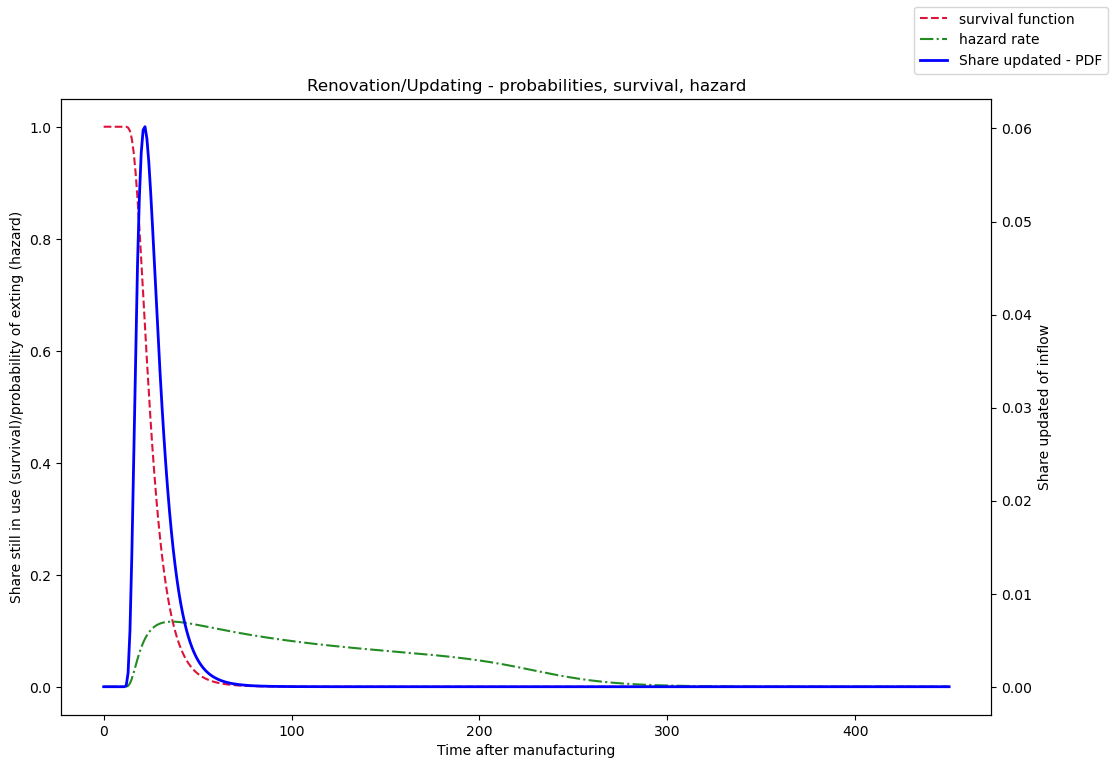

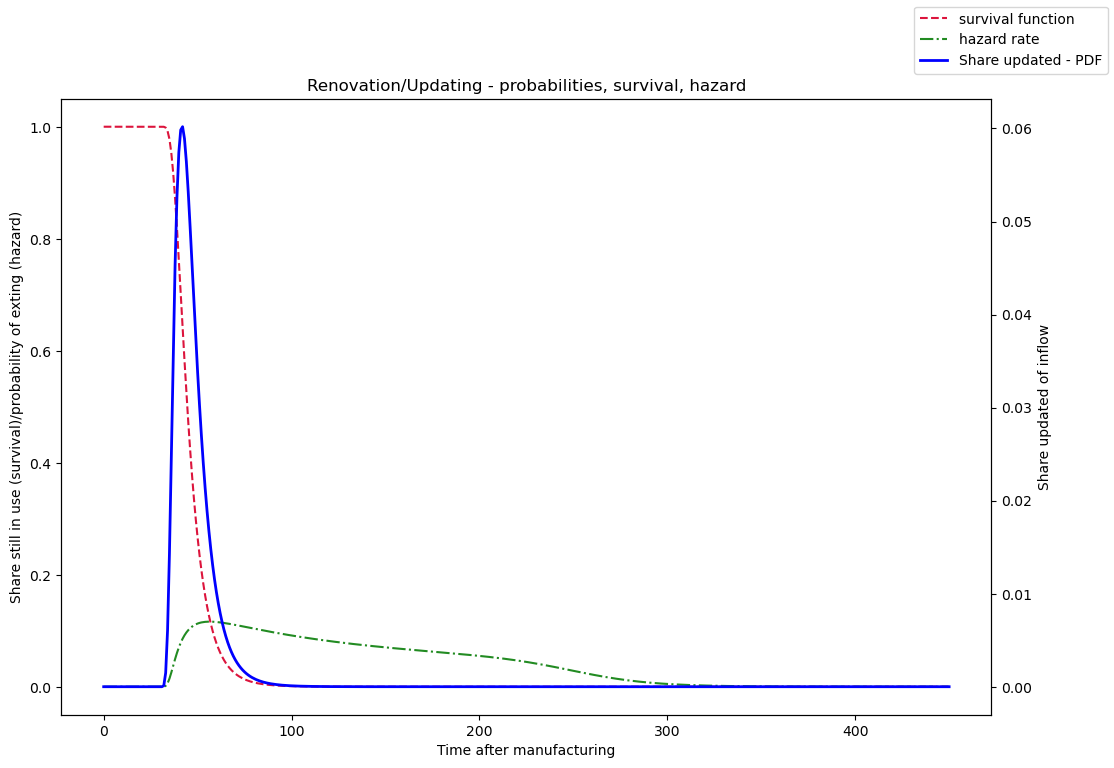

C:\Users\grace\OneDrive\Documents\Python\TEP4290_project\src/modules\renovation_state_modeling.py:354: UserWarning: Seems like your input stock contains non integers
  


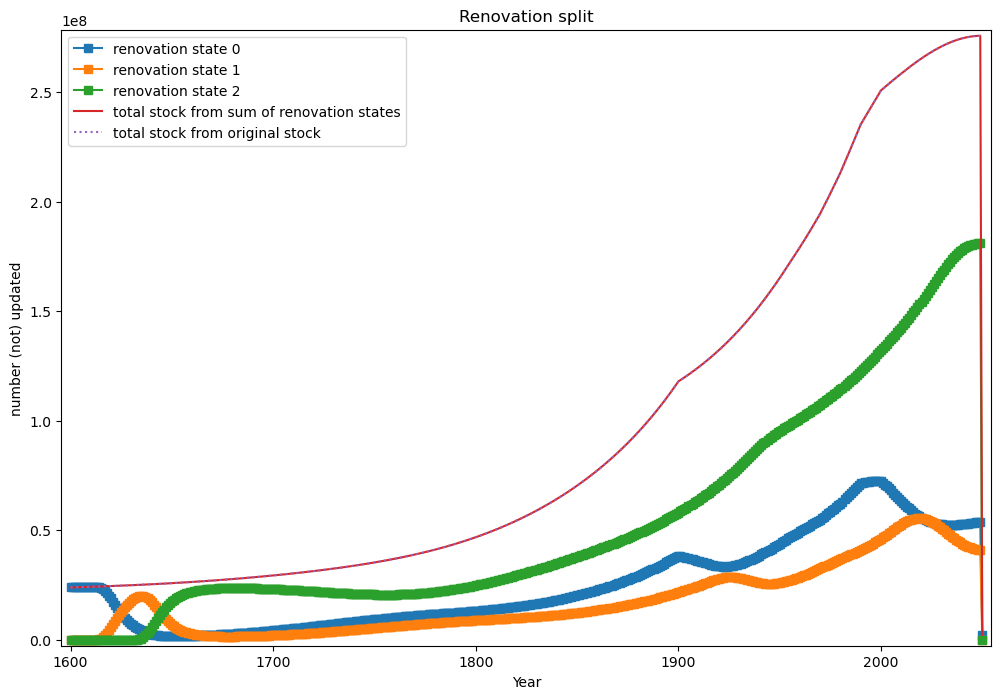

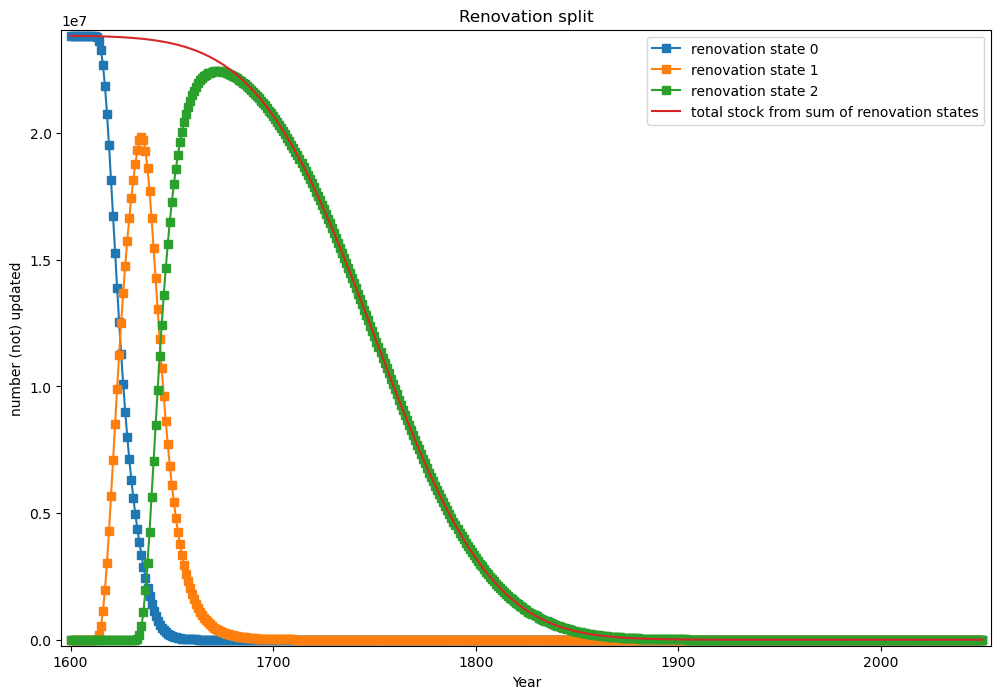

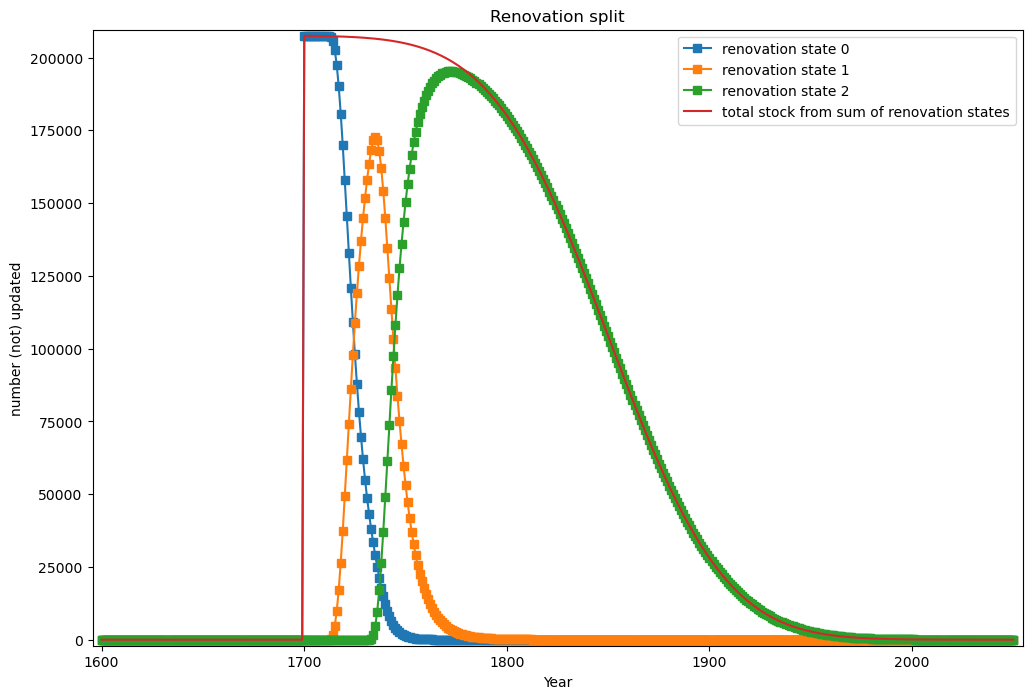

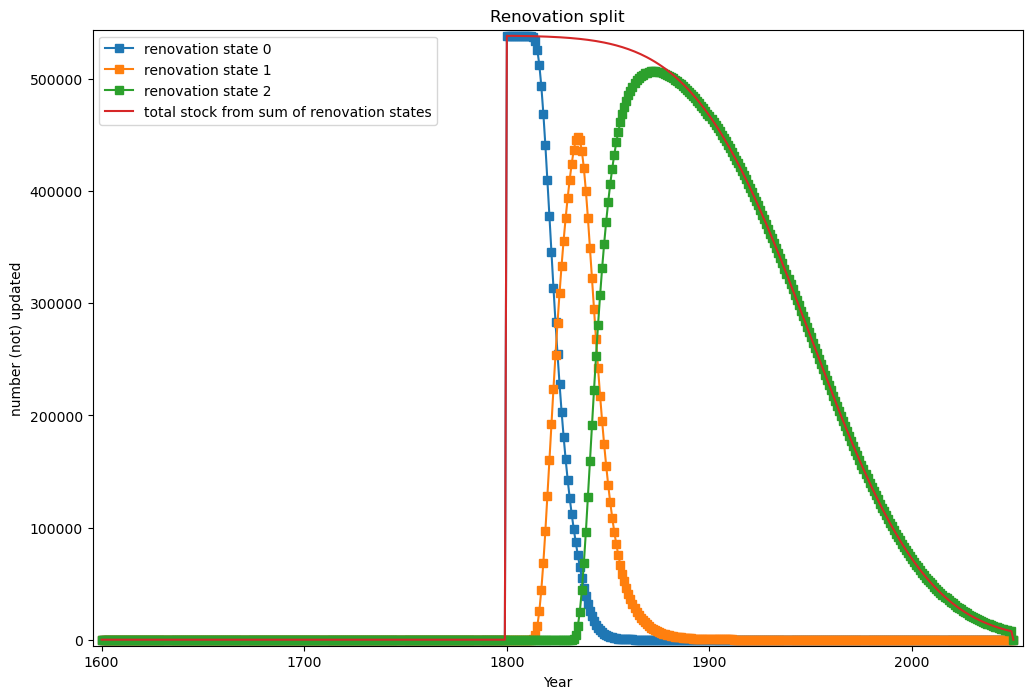

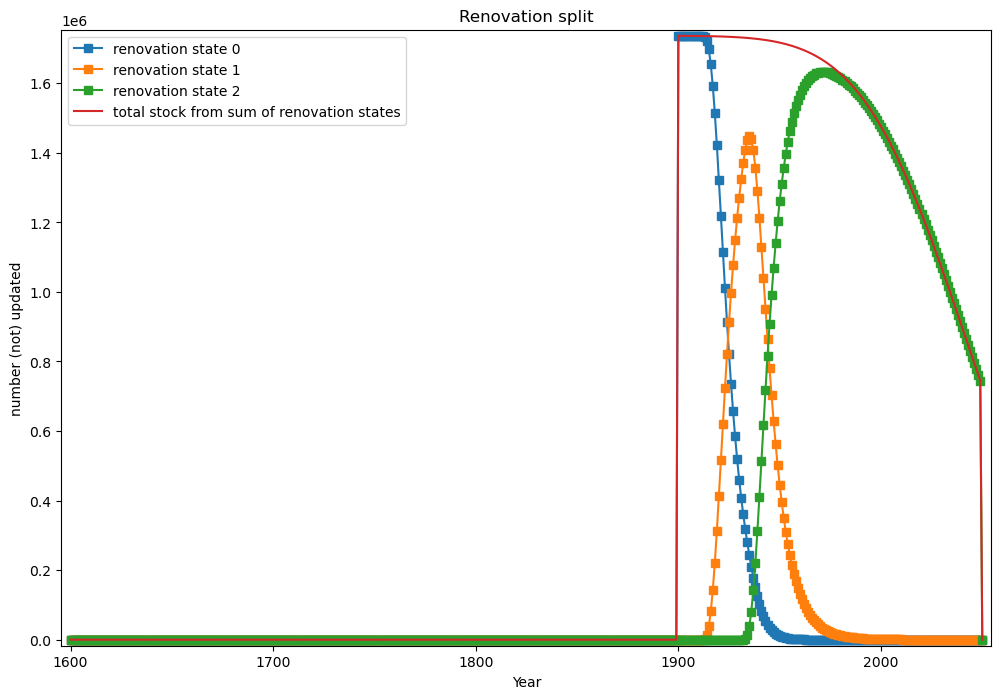

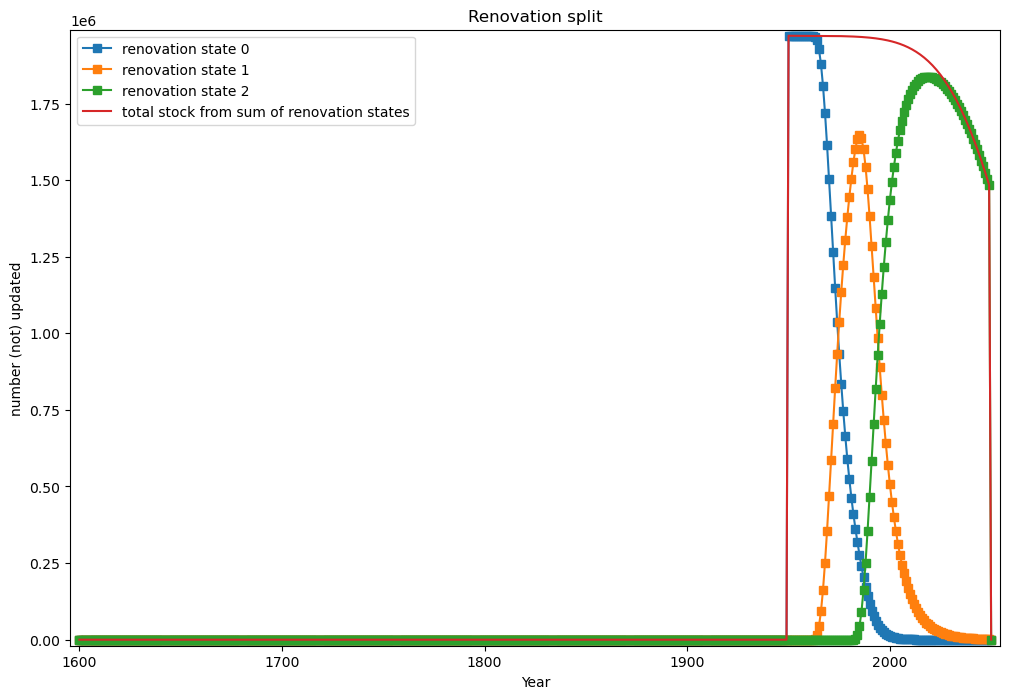

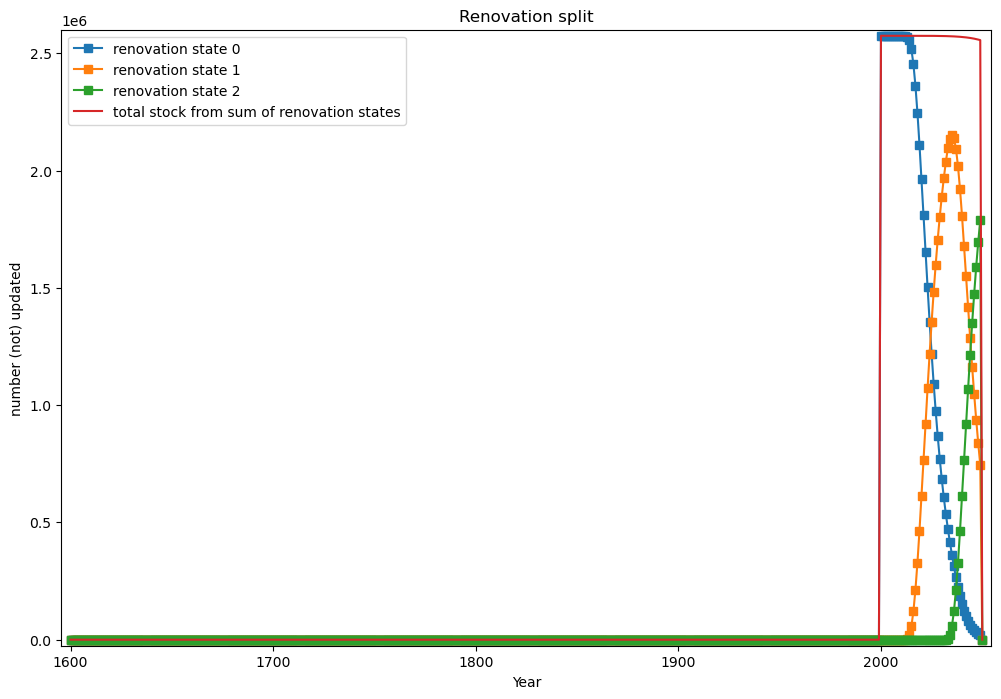

In [57]:
#SFH
ren_stock_model_SFH = RenovationStock(np.array(s_UFA_c_SFH), np.array(o_SFH_UFA), [renovation_cycle_avg, renovation_cycle_adv], np.array(s_UFA_c_SFH_df.index))
ren_stock_model_SFH.renovate()
ren_stock_model_SFH.plot_renovation_total_stock()
ren_stock_model_SFH.plot_renovation_states_cohort([0,100,200,300,350,400])
stock_tcr_SFH = ren_stock_model_SFH.s_tc_p_r

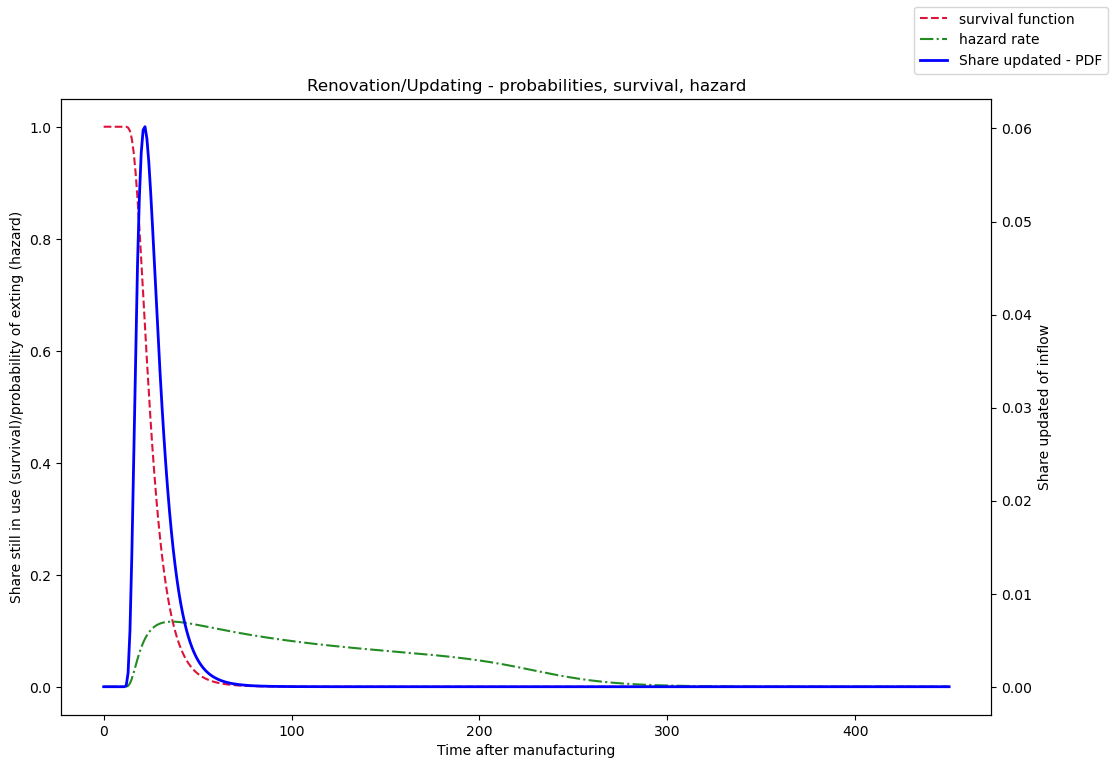

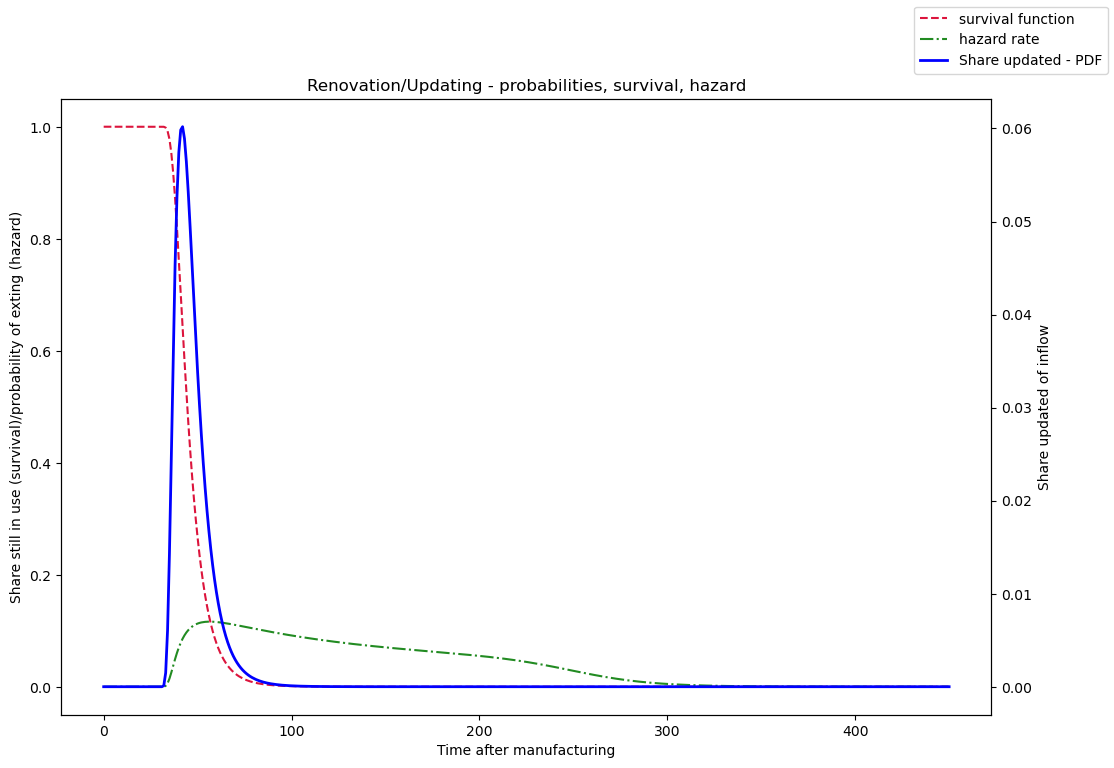

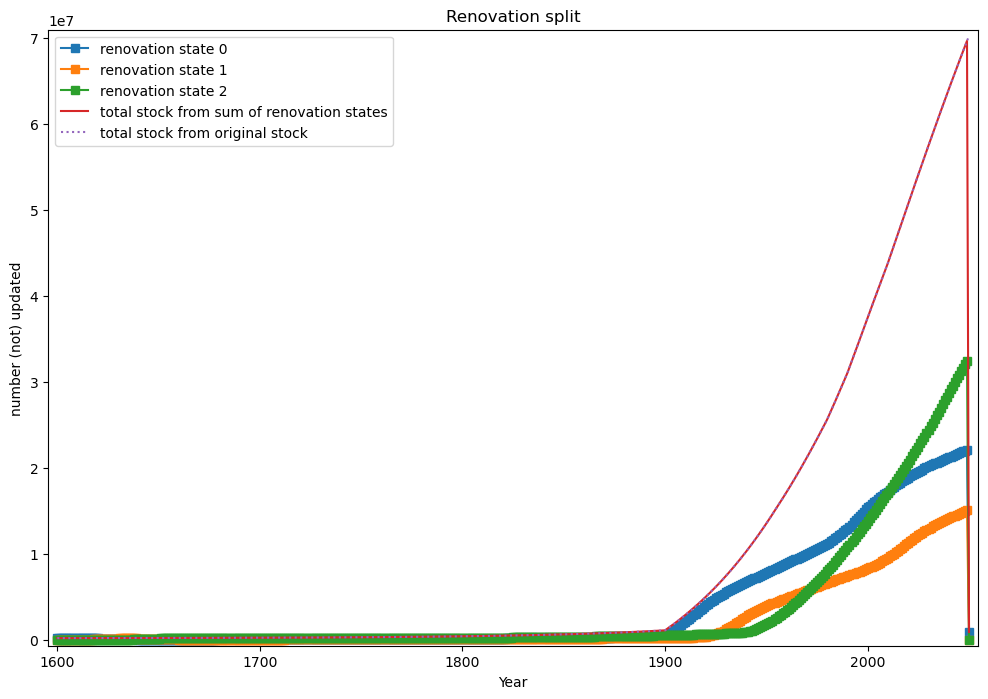

In [58]:
#TH
ren_stock_model_TH = RenovationStock(np.array(s_UFA_c_TH), np.array(o_TH_UFA), [renovation_cycle_avg, renovation_cycle_adv], s_UFA_c_SFH_df.index)
ren_stock_model_TH.renovate()
ren_stock_model_TH.plot_renovation_total_stock()
#ren_stock_model.plot_renovation_states_cohort([0,40,70])
stock_tcr_TH = ren_stock_model_TH.s_tc_p_r

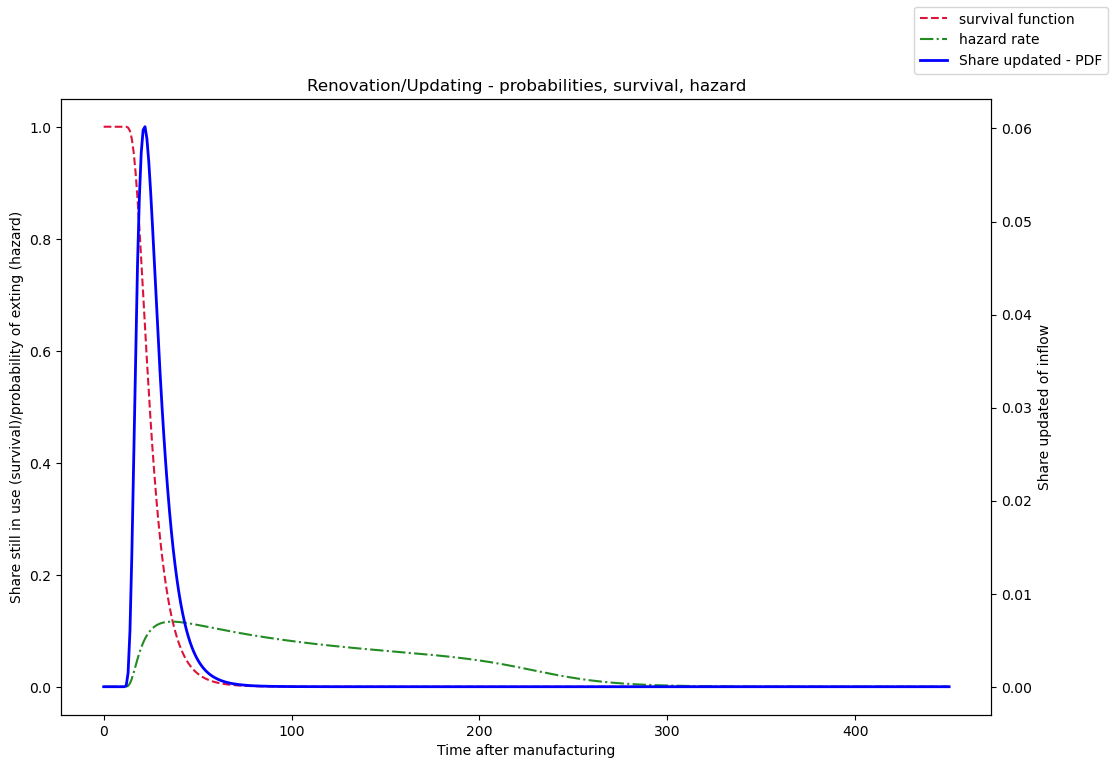

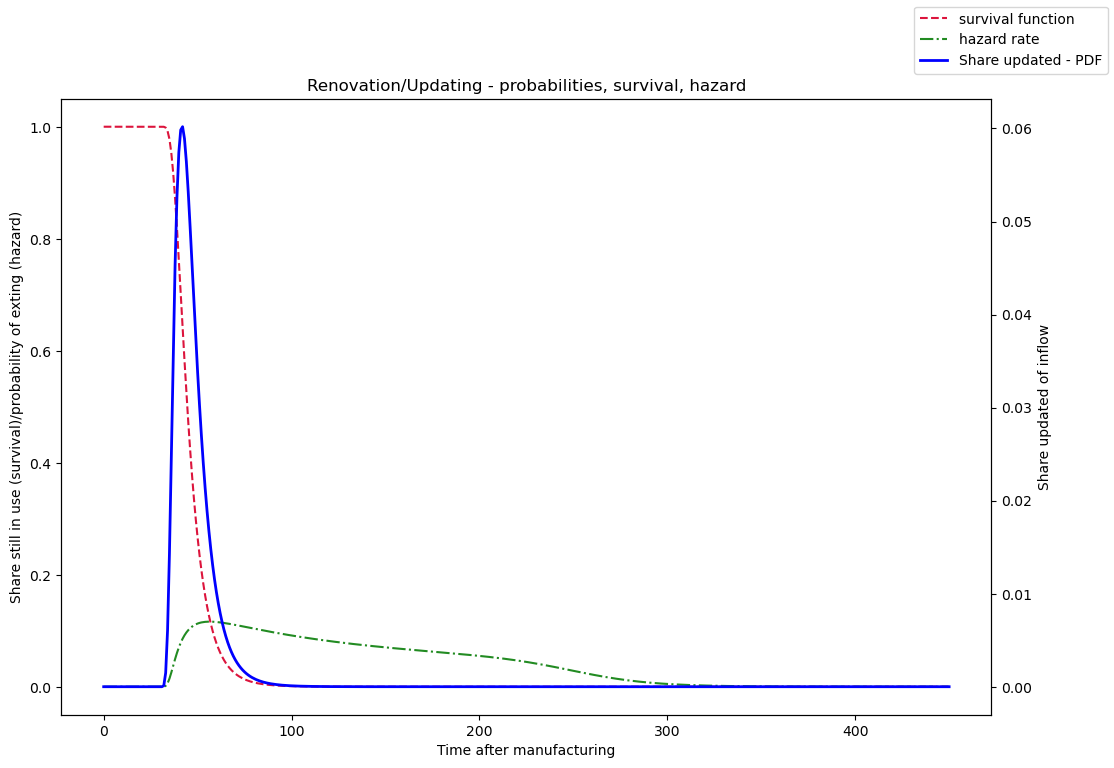

C:\Users\grace\OneDrive\Documents\Python\TEP4290_project\src/modules\renovation_state_modeling.py:359: RuntimeWarning: invalid value encountered in double_scalars
  warnings.warn(f'Your renovation stock in year {time} is more than 5% different to the original.')


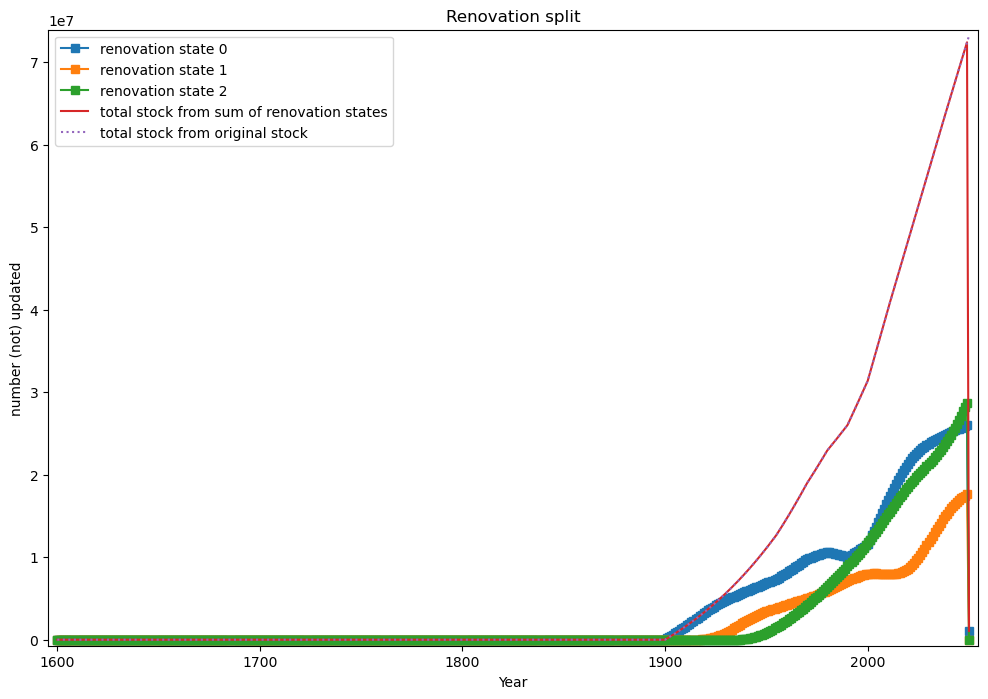

In [59]:
#AB
ren_stock_model_AB = RenovationStock(np.array(s_UFA_c_AB), np.array(o_AB_UFA), [renovation_cycle_avg, renovation_cycle_adv], s_UFA_c_SFH_df.index)
ren_stock_model_AB.renovate()
ren_stock_model_AB.plot_renovation_total_stock()
#ren_stock_model.plot_renovation_states_cohort([0,40,70])
stock_tcr_AB = ren_stock_model_AB.s_tc_p_r

Extend energy intensity to time dimension

In [60]:
# Move this up to the top of the file with the other load-ins at some point
EI_SFH = pd.read_excel(directory_path / 'data' / 'regression_data' / 'Energy_Intensity' / 'Energy_&_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='SFH_Energy', index_col=0)

EI_TH = pd.read_excel(directory_path / 'data' / 'regression_data' / 'Energy_Intensity' / 'Energy_&_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='TH_Energy', index_col=0)
    
EI_AB = pd.read_excel(directory_path / 'data' / 'regression_data' / 'Energy_Intensity' / 'Energy_&_Carbon_Intensity_Reformatted.xlsx',
    sheet_name='AB_Energy', index_col=0)

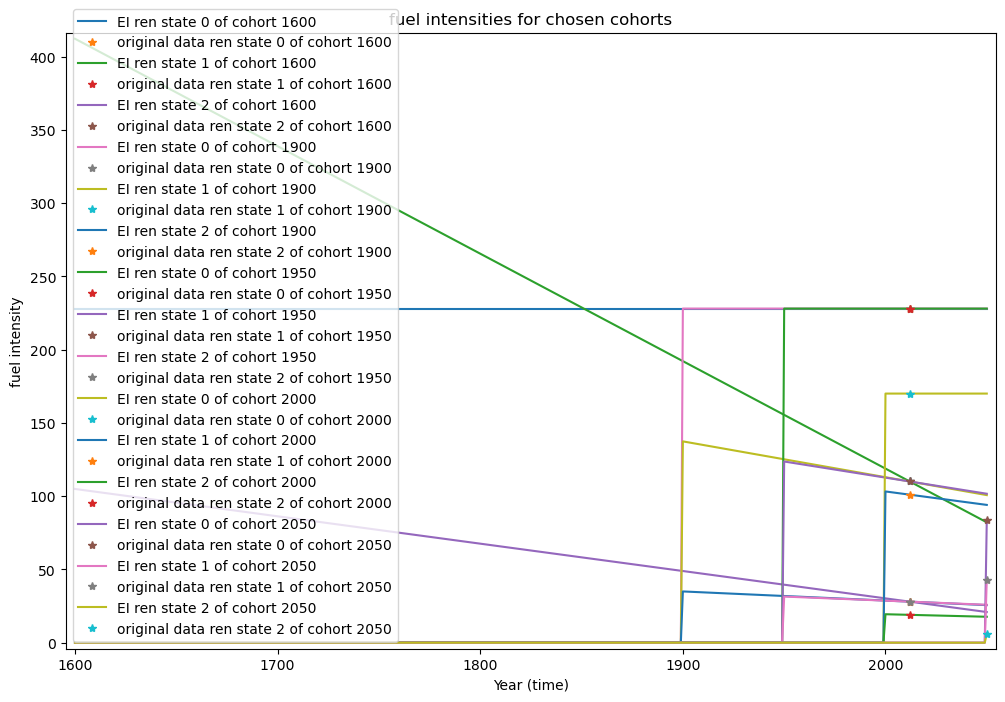

In [64]:
# source of energy intensity change over time: https://www.eea.europa.eu/data-and-maps/figures/odyssee-energy-efficiency-index-odex-1
no_ren = [1, 1] # slope of change
# maybe set the above to 1, 1
avg_ren = [3.74666, 0.74666] # slope of change
adv_ren = [3.74666, 0.74666] # slope of change


SFH_EI = EnergyIntensity(np.array(EI_SFH), 2012, np.array(s_UFA_c_SFH_df.index), adjustment_parameters=[no_ren, avg_ren, adv_ren])
#for later calculations
EI_tcr_SFH = SFH_EI.EI_tc_p_r

SFH_EI.plot_some_EIs([0,300,350,400,450])

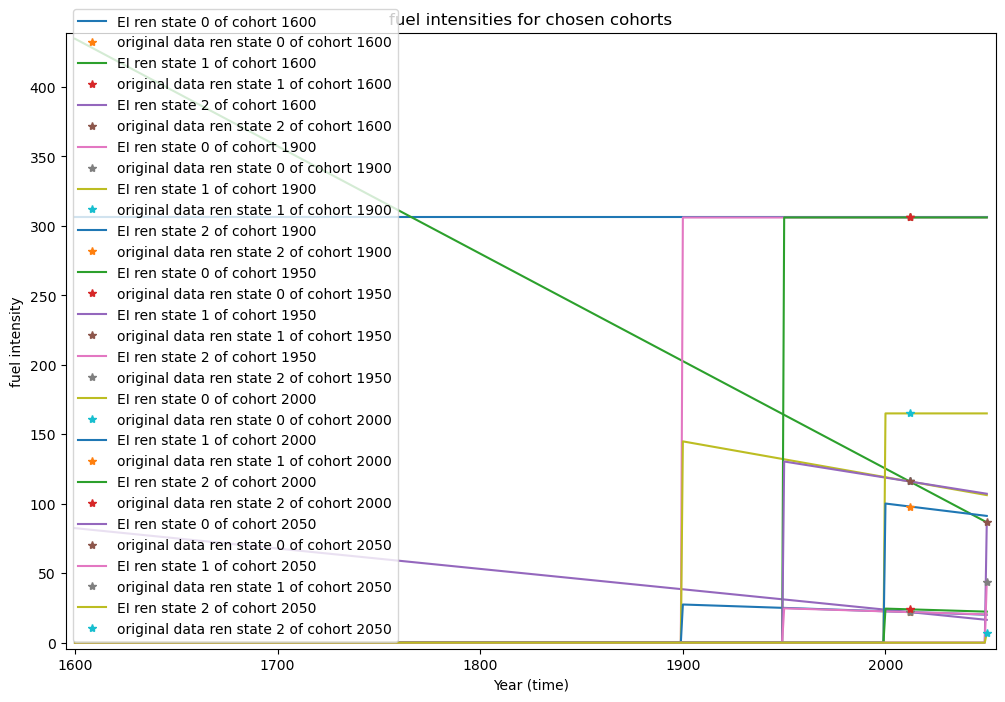

In [66]:
# source of energy intensity change over time: https://www.eea.europa.eu/data-and-maps/figures/odyssee-energy-efficiency-index-odex-1
no_ren = [1, 1] # slope of change
# maybe set the above to 1, 1
avg_ren = [3.74666, 0.74666] # slope of change
adv_ren = [3.74666, 0.74666] # slope of change


TH_EI = EnergyIntensity(np.array(EI_TH), 2012, np.array(s_UFA_c_SFH_df.index), adjustment_parameters=[no_ren, avg_ren, adv_ren])
#for later calculations
EI_tcr_TH = TH_EI.EI_tc_p_r

TH_EI.plot_some_EIs([0,300,350,400,450])

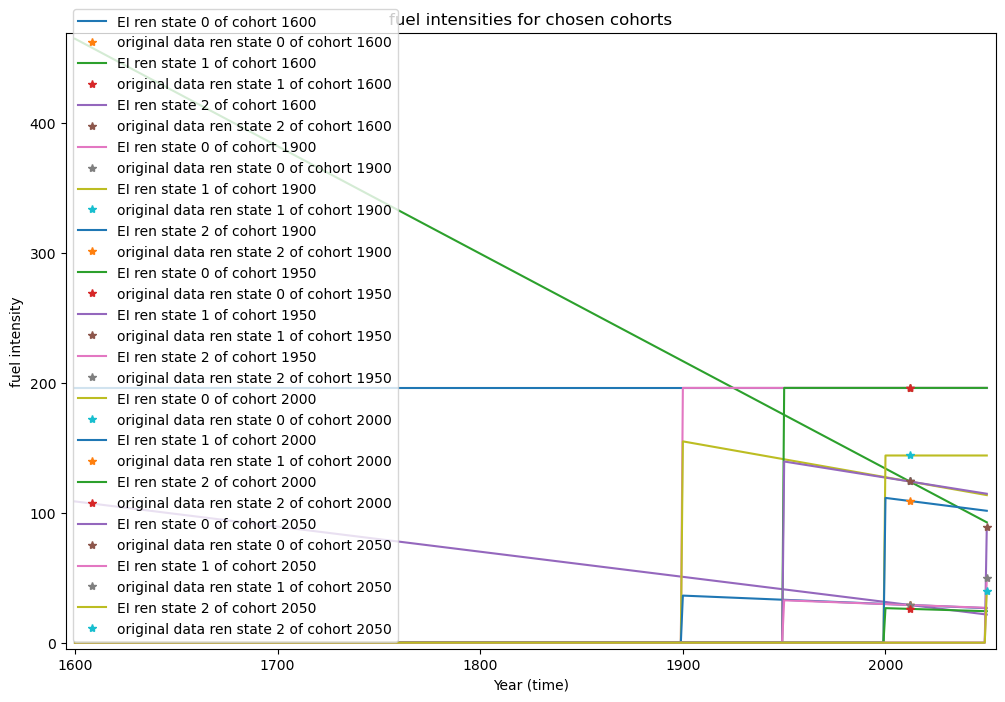

In [67]:
# source of energy intensity change over time: https://www.eea.europa.eu/data-and-maps/figures/odyssee-energy-efficiency-index-odex-1
no_ren = [1, 1] # slope of change
# maybe set the above to 1, 1
avg_ren = [3.74666, 0.74666] # slope of change
adv_ren = [3.74666, 0.74666] # slope of change


AB_EI = EnergyIntensity(np.array(EI_AB), 2012, np.array(s_UFA_c_SFH_df.index), adjustment_parameters=[no_ren, avg_ren, adv_ren])
#for later calculations
EI_tcr_AB = AB_EI.EI_tc_p_r

AB_EI.plot_some_EIs([0,300,350,400,450])

Calculate energy use for each type

Text(0.5, 0, 'Year')

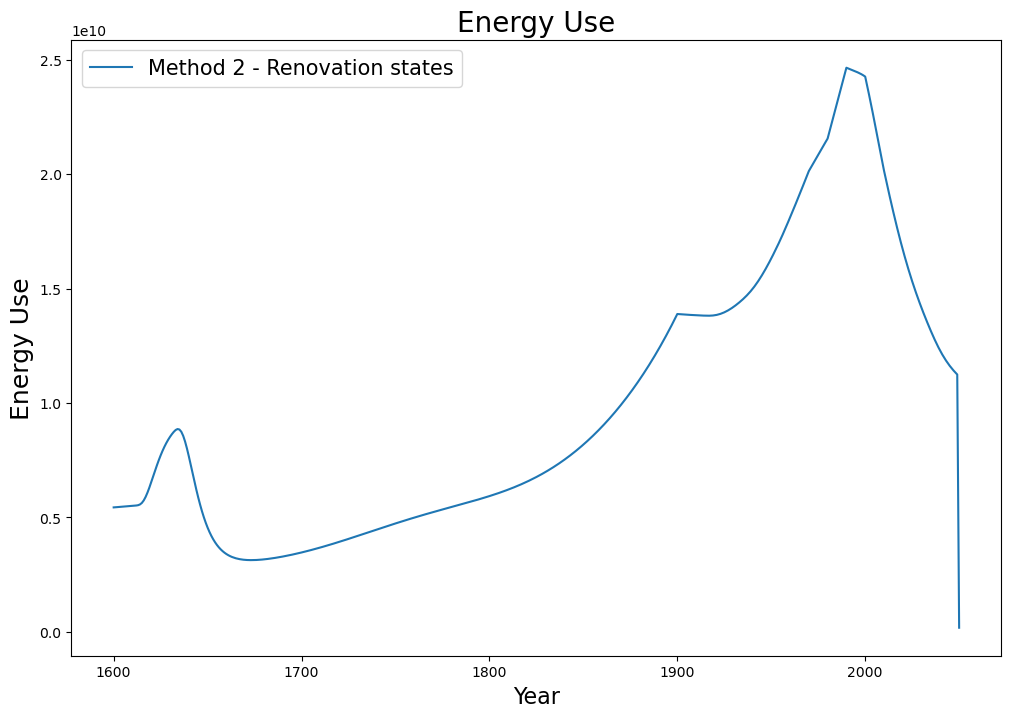

In [71]:
# Calculate energy consumption using the stock by vehicle and parts cohorts
# Calculations done where t = time, c = cohort, and r = renovation states
# Convert stock of vehicles to km driven
#km_driven = np.einsum('tcr, t-> tcr', stock_tcr, data['Kilometrage per vehicle'])
# Calculate fuel consumption based on vehicle efficiency
energy_use_SFH = np.einsum('tcr, tcr->t', stock_tcr_SFH, EI_tcr_SFH)

# Compare values with previous calculations without repairs and with Method 1 (Product Component Model)
fig = plt.figure(figsize=(12,8))

plt.plot(np.arange(1600,2051), energy_use_SFH, label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Text(0.5, 0, 'Year')

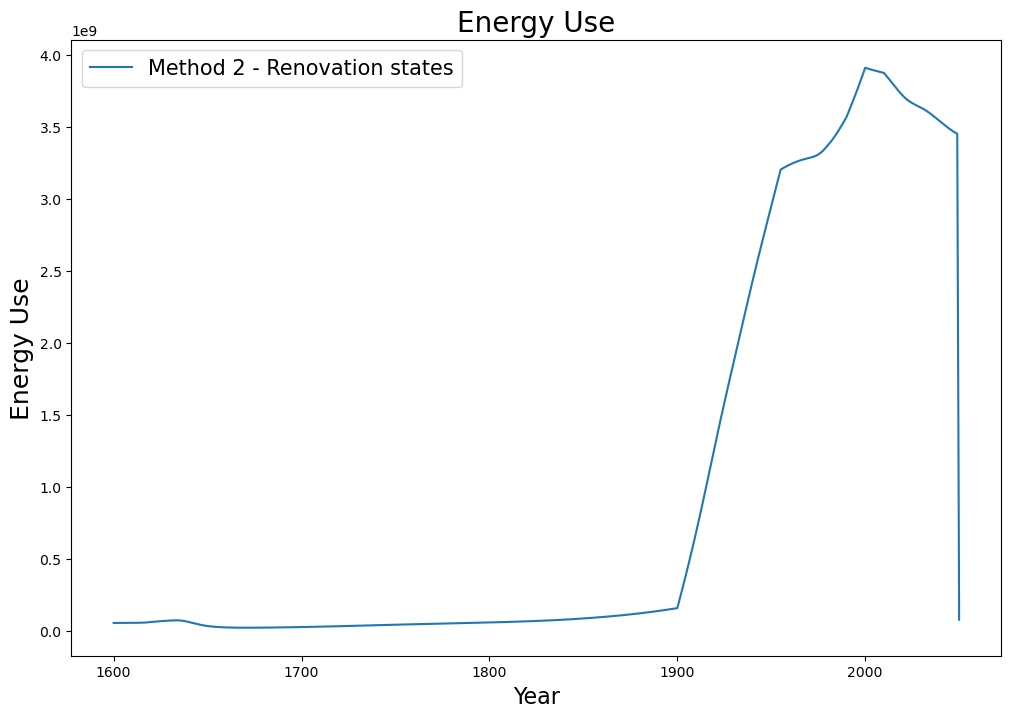

In [72]:
energy_use_TH = np.einsum('tcr, tcr->t', stock_tcr_TH, EI_tcr_TH)

# Compare values with previous calculations without repairs and with Method 1 (Product Component Model)
fig = plt.figure(figsize=(12,8))

plt.plot(np.arange(1600,2051), energy_use_TH, label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Text(0.5, 0, 'Year')

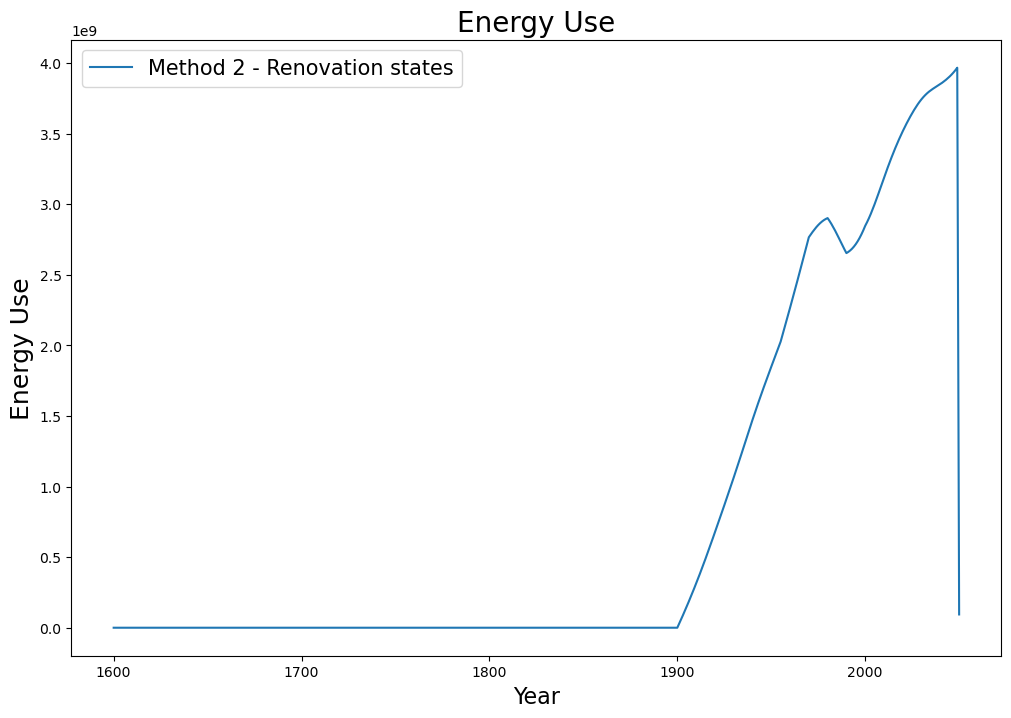

In [73]:
energy_use_AB = np.einsum('tcr, tcr->t', stock_tcr_AB, EI_tcr_AB)

# Compare values with previous calculations without repairs and with Method 1 (Product Component Model)
fig = plt.figure(figsize=(12,8))

plt.plot(np.arange(1600,2051), energy_use_AB, label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Sum for total energy use

Text(0.5, 0, 'Year')

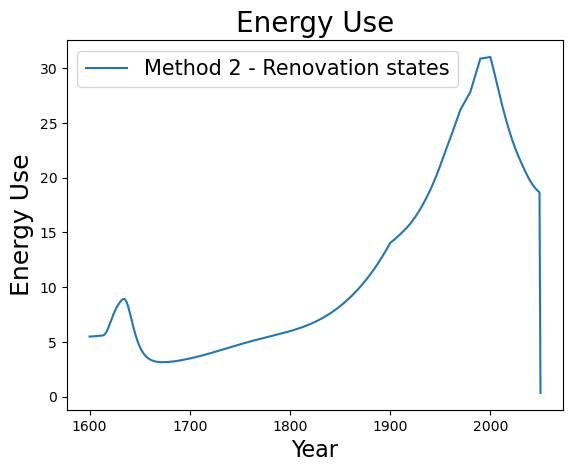

In [79]:
energy_use_SFH_df = pd.DataFrame(energy_use_SFH)
energy_use_TH_df = pd.DataFrame(energy_use_TH)
energy_use_AB_df = pd.DataFrame(energy_use_AB)

total_energy_use = energy_use_SFH_df + energy_use_TH_df + energy_use_AB_df
total_energy_use

plt.plot(np.arange(1600,2051), total_energy_use/1000000000, label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Define a function that calculates energy use for SFH, original renovation level

In [ ]:
def energy_use_calculation_SFH(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('pre 1955' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1956-70' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1971-80' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1981-90' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('1991-2000' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('2001-2010' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_SFH.loc[:, year],energy_intensity.loc[('2011-' , 'SFH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

Run function that spits out energy use of SFH by DSM cohort

In [ ]:
energy_use_matrix_SFH = energy_use_calculation_SFH(s_UFA_c_SFH)

calculate vector of energy use for SFH (not by cohort)

In [ ]:
energy_use_vector_SFH = energy_use_matrix_SFH.sum(axis=1)

Define a function that calculates energy use for TH, original renovation level

In [ ]:
def energy_use_calculation_TH(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('pre 1955' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1956-70' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1971-80' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1981-90' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('1991-2000' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('2001-2010' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_TH.loc[:, year],energy_intensity.loc[('2011-' , 'TH', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

Run function that spits out energy use of TH by DSM cohort

In [ ]:
energy_use_matrix_TH = energy_use_calculation_TH(s_UFA_c_TH)

calculate vector of energy use for TH (not by cohort)

In [ ]:
energy_use_vector_TH = energy_use_matrix_TH.sum(axis=1)

Define a function that calculates energy use for AB, original renovation level

In [ ]:
def energy_use_calculation_AB(stock_c_UFA):
    energy_use_matrix = pd.DataFrame()
    for year in stock_c_UFA.columns:
        if int(year) <= 1955:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('pre 1955' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1956-70' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1971-80' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1981-90' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('1991-2000' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('2001-2010' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
        elif int(year) >= 2011:
            iteration = pd.DataFrame(np.multiply(s_UFA_c_AB.loc[:, year],energy_intensity.loc[('2011-' , 'AB', 'OG'),'Energy intensity  (kWh/m2a)']))
            energy_use_matrix = pd.concat([energy_use_matrix, iteration], axis=1)
    return energy_use_matrix

Run function that spits out energy use of AB by DSM cohort

In [ ]:
energy_use_matrix_AB = energy_use_calculation_AB(s_UFA_c_AB)

calculate vector of energy use for AB (not by cohort)

In [ ]:
energy_use_vector_AB = energy_use_matrix_AB.sum(axis=1)

Calculate total energy use matrix

In [ ]:
energy_use_matrix_total = energy_use_matrix_SFH + energy_use_matrix_TH + energy_use_matrix_AB

Concatenate energy use vectors

In [ ]:
energy_use_vectors_concatenated = pd.concat([energy_use_vector_SFH, energy_use_vector_TH, energy_use_vector_AB], axis=1)
energy_use_vectors_concatenated = energy_use_vectors_concatenated.rename(columns={0: 'SFH', 1: 'TH', 2: 'AB'})

#energy_use_vectors_concatenated = pd.concat([energy_use_vectors_concatenat1, energy_use_vector_AB], axis=1)

energy_use_vectors_concatenated 

Put energy use matrix into tabula cohorts

In [ ]:
energy_use_matrix_total_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(energy_use_matrix_total).loc[:,'1600':'1955'].sum(axis=1)/1000000000, 
          '1956-1970': pd.DataFrame(energy_use_matrix_total).loc[:,'1956':'1970'].sum(axis=1)/1000000000, 
          '1971-1980': pd.DataFrame(energy_use_matrix_total).loc[:,'1971':'1980'].sum(axis=1)/1000000000, 
          '1981-1990': pd.DataFrame(energy_use_matrix_total).loc[:,'1981':'1990'].sum(axis=1)/1000000000, 
          '1991-2000': pd.DataFrame(energy_use_matrix_total).loc[:,'1991':'2000'].sum(axis=1)/1000000000, 
          '2001-2010': pd.DataFrame(energy_use_matrix_total).loc[:,'2001':'2010'].sum(axis=1)/1000000000, 
          'post-2010': pd.DataFrame(energy_use_matrix_total).loc[:,'2011':'2050'].sum(axis=1)/1000000000}
          )

Calculate total energy use

In [ ]:
total_energy_use = energy_use_vector_SFH + energy_use_vector_TH + energy_use_vector_AB

Export model outputs

In [ ]:
s_SFH_df.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/s_SFH.xlsx')

s_TH_df.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/s_TH.xlsx')

s_AB_df.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/s_AB.xlsx')

SFH_stock_by_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/s_c_SFH.xlsx')

TH_stock_by_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/s_c_TH.xlsx')

AB_stock_by_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/s_c_AB.xlsx')

stock_change_total.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/s_delta_total.xlsx')

total_stock_by_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/s_c_total.xlsx')

pd.DataFrame(i_SFH).to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/i_SFH.xlsx')

pd.DataFrame(i_TH).to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/i_TH.xlsx')

pd.DataFrame(i_AB).to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/i_AB.xlsx')

o_total.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/o_total.xlsx')

i_total.to_excel(directory_path / 
                 'data/model_outputs_baseline/number_of_dwellings/i_total.xlsx')

s_UFA_c_SFH_df.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/s_UFA_c_SFH.xlsx')

s_UFA_c_TH_df.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/s_UFA_c_TH.xlsx')

s_UFA_c_AB_df.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/s_UFA_c_AB.xlsx')

SFH_UFA_stock_by_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/s_UFA_tabula_SFH.xlsx')

TH_UFA_stock_by_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/s_UFA_tabula_TH.xlsx')

AB_UFA_stock_by_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/s_UFA_tabula_AB.xlsx')

stock_change_total_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/s_delta_total_UFA.xlsx')

total_stock_UFA_by_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/s_UFA_tabula_total.xlsx')

i_SFH_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/i_SFH_UFA.xlsx')

i_TH_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/i_TH_UFA.xlsx')

i_AB_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/i_AB_UFA.xlsx')

o_total_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/o_total_UFA.xlsx')

i_total_UFA.to_excel(directory_path / 
                 'data/model_outputs_baseline/UFA/i_total_UFA.xlsx')

energy_use_vector_SFH.to_excel(directory_path / 
                 'data/model_outputs_baseline/energy/energy_use_vector_SFH.xlsx')

energy_use_vector_TH.to_excel(directory_path / 
                 'data/model_outputs_baseline/energy/energy_use_vector_TH.xlsx')

energy_use_vector_AB.to_excel(directory_path / 
                 'data/model_outputs_baseline/energy/energy_use_vector_AB.xlsx')

energy_use_matrix_total_tabula_cohort.to_excel(directory_path / 
                 'data/model_outputs_baseline/energy/energy_use_matrix_total_tabula.xlsx')

total_energy_use.to_excel(directory_path / 
                 'data/model_outputs_baseline/energy/total_energy_use.xlsx')